In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow numpy matplotlib scikit-learn opencv-python-headless seaborn


In [4]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install opencv-python-headless


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import cv2
import pandas as pd


# **Load and Preprocess the Dataset**

In [6]:
dataset_dir = '/content/drive/MyDrive/LEARNFLOW dataset/archive/images'  

# Load images and labels
data = []
labels = []

for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img)
            data.append(img_array)
            labels.append(folder)

# Convert to numpy arrays
data = np.array(data, dtype='float32') / 255.0
labels = np.array(labels)

# Encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)


# **Implementation of K-Fold Cross-Validation and Train the Model**

In [7]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []
histories = []
confusion_matrices = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []

for train, val in kfold.split(data, labels.argmax(1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(19, activation='softmax') # Since my Data set consists of 19 folders
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    print(f'Training fold {fold_no} ...')

    history = model.fit(
        data[train], labels[train],
        epochs=25,
        batch_size=32,
        validation_data=(data[val], labels[val])
    )

    scores = model.evaluate(data[val], labels[val], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    histories.append(history)

    # Predictions
    predictions = model.predict(data[val])
    y_true = labels[val].argmax(axis=1)
    y_pred = predictions.argmax(axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    confusion_matrices.append(cm)

    # Precision, Recall, F1 Score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    fold_no += 1

# Printing average accuracy, loss, precision, recall, and F1 score
print('Average accuracy:', np.mean(accuracy_per_fold))
print('Average loss:', np.mean(loss_per_fold))
print('Average precision:', np.mean(precision_per_fold))
print('Average recall:', np.mean(recall_per_fold))
print('Average F1 score:', np.mean(f1_per_fold))


Training fold 1 ...
Epoch 1/25
4/4 [==============================] - 19s 3s/step - loss: 3.1432 - accuracy: 0.0400 - val_loss: 2.7197 - val_accuracy: 0.2188
Epoch 2/25
4/4 [==============================] - 9s 2s/step - loss: 2.4787 - accuracy: 0.3120 - val_loss: 1.8106 - val_accuracy: 0.6562
Epoch 3/25
4/4 [==============================] - 7s 2s/step - loss: 1.3178 - accuracy: 0.6400 - val_loss: 0.5606 - val_accuracy: 0.9688
Epoch 4/25
4/4 [==============================] - 9s 2s/step - loss: 0.4499 - accuracy: 0.8880 - val_loss: 0.0853 - val_accuracy: 1.0000
Epoch 5/25
4/4 [==============================] - 7s 2s/step - loss: 0.1406 - accuracy: 0.9520 - val_loss: 0.1252 - val_accuracy: 0.9375
Epoch 6/25
4/4 [==============================] - 9s 2s/step - loss: 0.1601 - accuracy: 0.9600 - val_loss: 0.0763 - val_accuracy: 0.9688
Epoch 7/25
4/4 [==============================] - 7s 2s/step - loss: 0.0752 - accuracy: 0.9760 - val_loss: 0.0419 - val_accuracy: 1.0000
Epoch 8/25
4/4 [====

1/1 [==============================] - 0s 439ms/step
Average accuracy: 98.72983813285828
Average loss: 0.06542173302732408
Average precision: 0.9926075268817204
Average recall: 0.9872983870967742
Average F1 score: 0.9868817204301076


# **Visualizing Confusion Matrix for Each Fold**

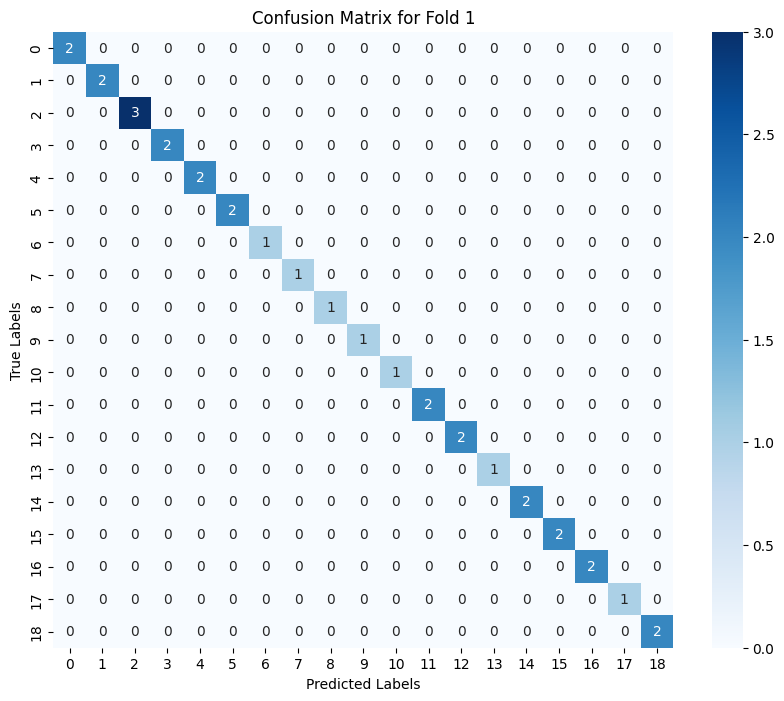

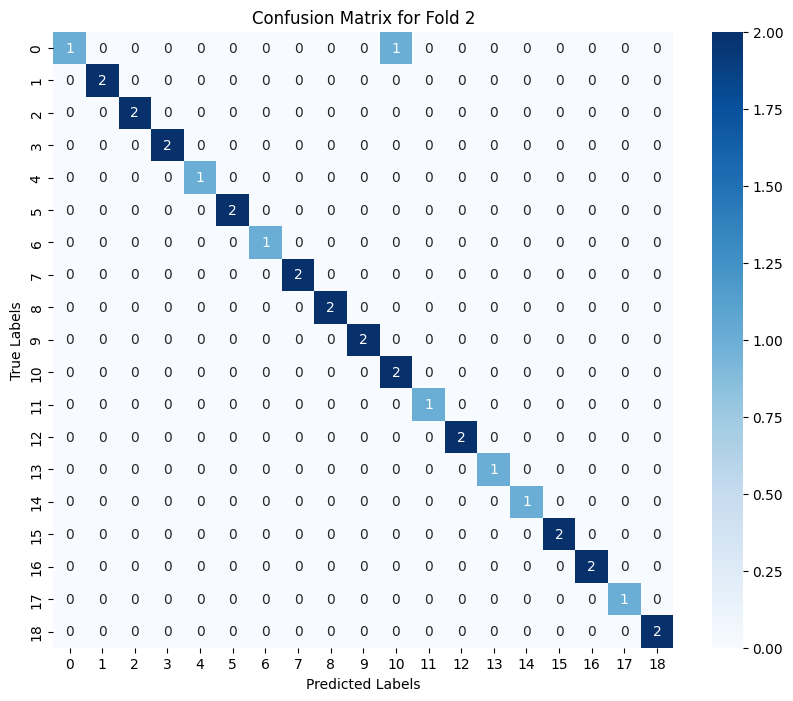

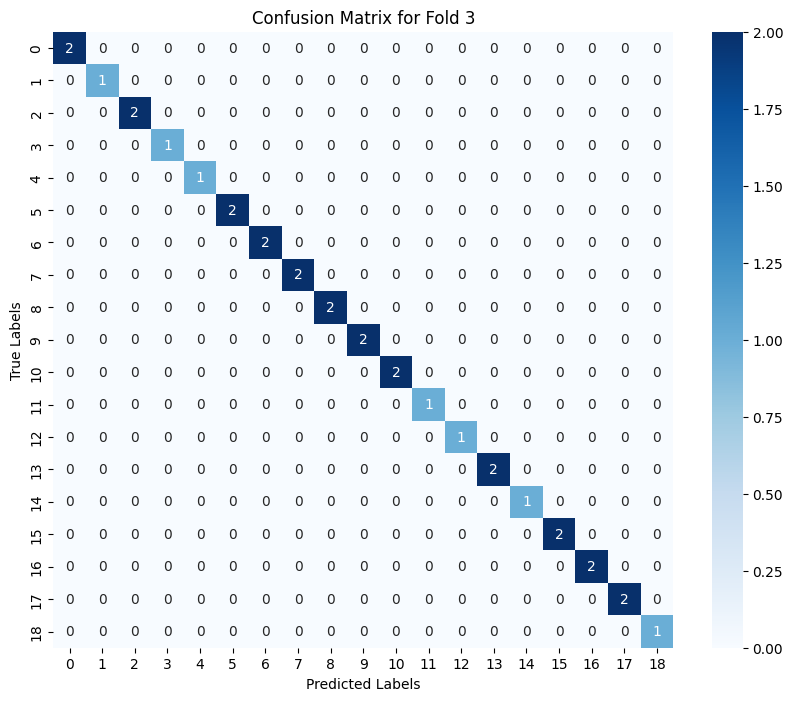

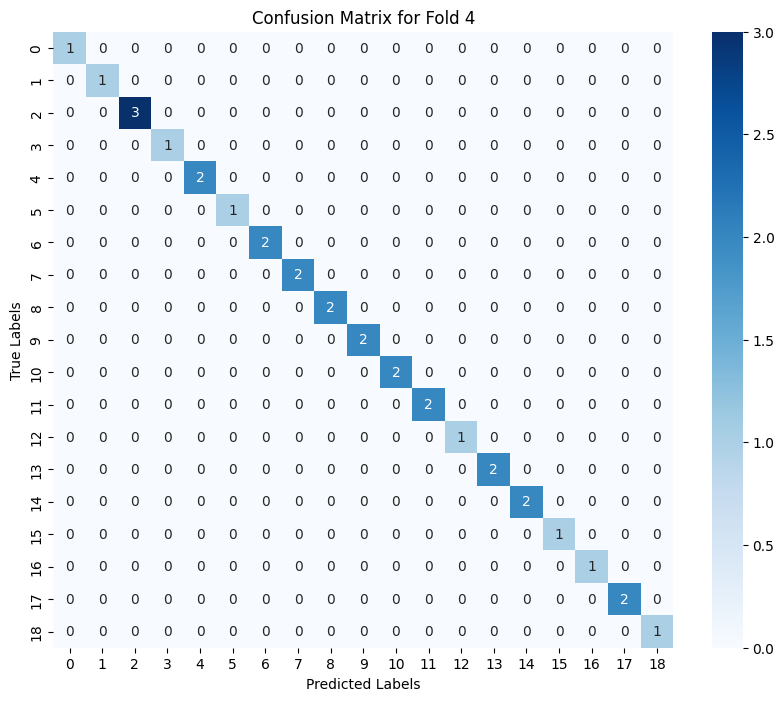

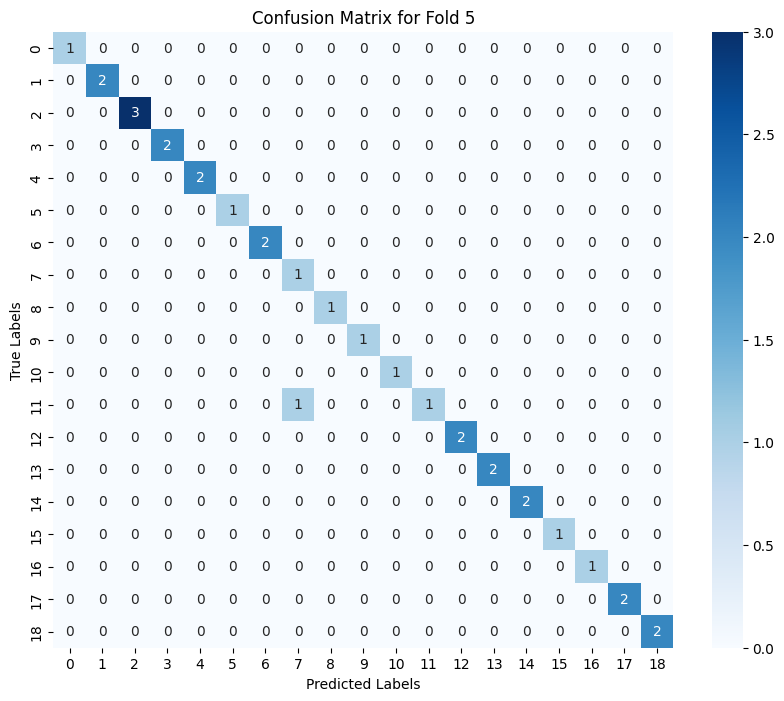

In [8]:
for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {i+1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


# **Classification Report for Each Fold**

In [9]:
for i, (train, val) in enumerate(kfold.split(data, labels.argmax(1))):
    print(f'Classification Report for Fold {i+1}')
    predictions = model.predict(data[val])
    y_true = labels[val].argmax(axis=1)
    y_pred = predictions.argmax(axis=1)
    print(classification_report(y_true, y_pred, target_names=lb.classes_))


Classification Report for Fold 1
1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         

# **Visualizing**

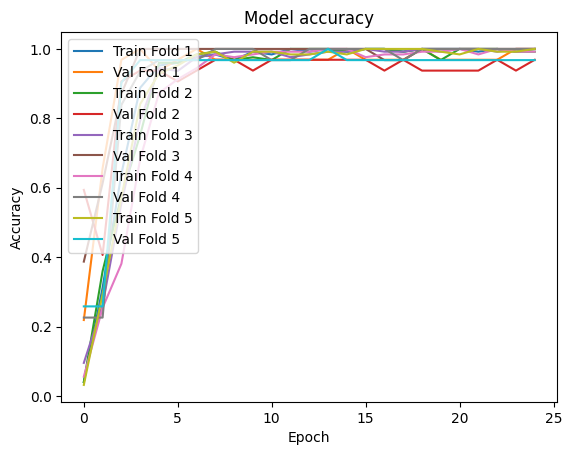

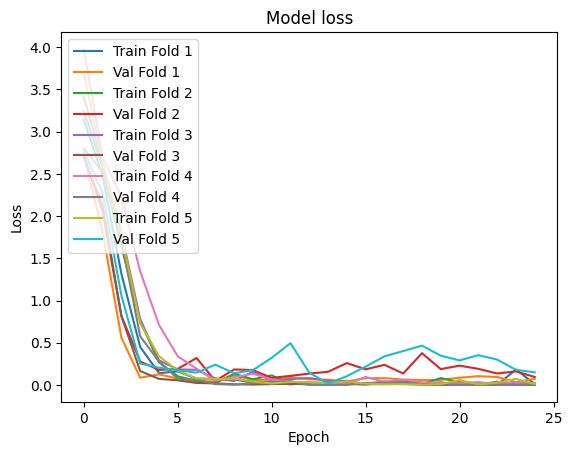

In [10]:
# Plotting training and validation accuracy for each fold
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Fold {i+1}')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plotting training and validation loss for each fold
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Fold {i+1}')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
